In [1]:
# import libraries 
import pandas as pd
import matplotlib.pyplot as plt
import os 
import math
import sys
from pathlib import Path
import seaborn as sns
from fontTools.unicodedata import block

# Add 'src' to the system path
sys.path.append(str(Path().resolve() / 'src'))
from src.data.process_data import *
from src.data.clean_data import *
from src.utils.data_utils import *
from src.utils.plot_utils import *

IMPORTANT: these scripts/functions assume you have the following files in the data/raw directory:
- From the CMU dataset: 
    - movie.metadata.tsv
    - plot_summaries.txt
- From the TMDB dataset: 
    - TMDB_movie_dataset_v11.csv

AND have data/processed folder created

Note: download CMU dataset here: https://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz
and TMDB dataset here (Download button): https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies

In [2]:
# from raw files, creates clean datafiles
%run src/data/clean_data.py

Loading data from data/raw/TMDB_movie_dataset_v11.csv...
original df shape (1127777, 24)
after status (1102507, 24)
after adult (997822, 24)
after release date (669758, 24)
after release year (669758, 25)
after runtime (669292, 25)
after duplicates (656104, 25)
after numeric columns (656103, 25)
after select columns (656103, 13)
Loading data from data/raw/movie.metadata.tsv...
original df shape (81740, 9)
after release year (44006, 9)
after runtime (36612, 9)
after duplicates (36548, 9)
after numeric columns (36548, 9)
after select columns (36548, 5)
Loading data from data/raw/plot_summaries.txt...


In [113]:
# from clean data files, creates a dataframe with CMU + plots & TMDB movies 
%run src/data/process_data.py
df_combined = create_cmu_tmdb_dataset('data/processed/movies.csv','data/processed/plot_summaries.csv', 'data/processed/TMDB_clean.csv', 'inner')
df_tmdb = create_tmdb_dataset('data/processed/TMDB_clean.csv')

In [114]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17548 entries, 0 to 17547
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   title                 17548 non-null  object
 1   release_year          17548 non-null  int64 
 2   summary               17548 non-null  object
 3   release_date          17548 non-null  object
 4   budget                17548 non-null  int64 
 5   original_language     17548 non-null  object
 6   overview              17548 non-null  object
 7   genres                17548 non-null  object
 8   production_companies  17548 non-null  object
 9   production_countries  17548 non-null  object
 10  spoken_languages      17548 non-null  object
 11  keywords              17548 non-null  object
 12  revenue               17548 non-null  int64 
 13  runtime               17548 non-null  int64 
 14  dvd_era               17548 non-null  object
dtypes: int64(4), object(11)
memory usage

In [115]:
df_combined.head()

,title,release_year,summary,release_date,budget,original_language,overview,genres,production_companies,production_countries,spoken_languages,keywords,revenue,runtime,dvd_era
0,White Of The Eye,1987,A series of murders of rich young women throug...,1987-06-19,0,en,"In a wealthy and isolated desert community, a ...","[Horror, Thriller]",[Mrs. White's Productions],[United Kingdom],[English],"[based on novel or book, gas station, psychopa...",0,221,pre
1,A Woman in Flames,1983,"Eva, an upper class housewife, becomes frustra...",1983-05-11,0,de,"Eva, an upper-class housewife, frustratedly le...",[Drama],[Dieter Geissler Filmproduktion],[Germany],[German],"[jealousy, eroticism, gigolo, longing, dominat...",0,212,pre
2,The Sorcerer's Apprentice,2002,"Every hundred years, the evil Morgana returns...",2002-04-12,0,en,"Every hundred years, the evil sorceress Morgan...","[Adventure, Family, Fantasy]","[Peakviewing Productions, Peakviewing Transatl...",[United Kingdom],"[French, English]",[morgana],0,172,during
3,Little city,1997,"Adam, a San Francisco-based artist who works a...",1997-04-04,0,en,Best friends Adam and Kevin have a lot in comm...,"[Comedy, Romance]","[Bandeira Entertainment, Miramax]",[],[English],[],0,183,pre
4,Henry V,1989,{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,1989-10-05,9000000,en,Gritty adaption of William Shakespeare's play ...,"[War, Drama, History]","[BBC Film, Renaissance Films, Samuel Goldwyn C...",[United Kingdom],[English],"[france, kingdom, theater play, based on true ...",20337800,274,pre


In [116]:
%run src/utils/data_utils.py
%run src/utils/plot_utils.py

# CMU dataset

## Production companies

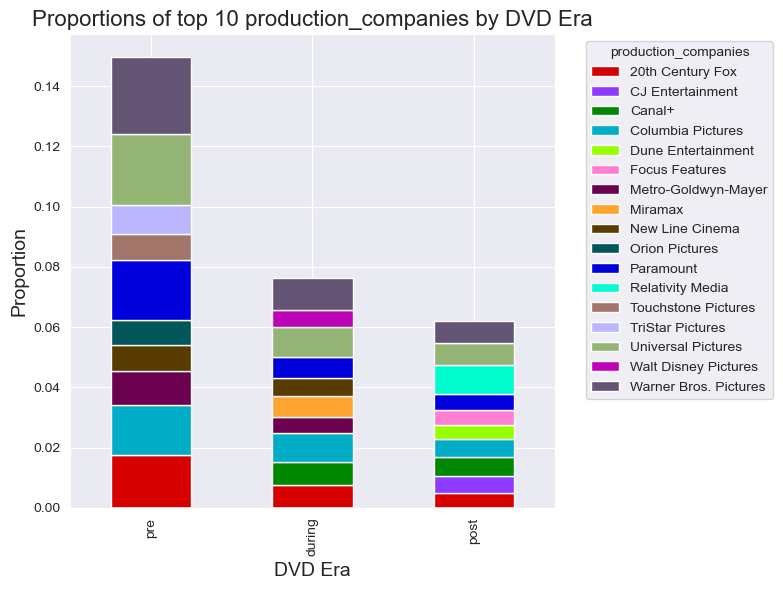

In [117]:
top_10_prod_companies = top_proportions_per_era(df_combined, 'production_companies', 10, islist=True)
plot_top_proportions_per_era(top_10_prod_companies, 'production_companies', 10)

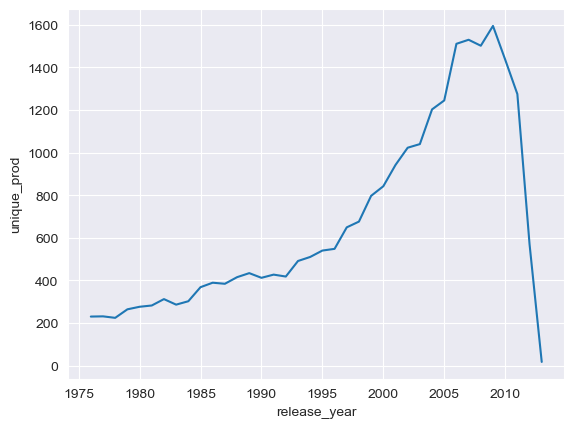

In [118]:
num_production_companies_per_year = df_combined.explode('production_companies').groupby('release_year')['production_companies'].nunique().reset_index(name='unique_prod')
sns.lineplot(data=num_production_companies_per_year, x='release_year', y='unique_prod')
plt.show()

## Countries

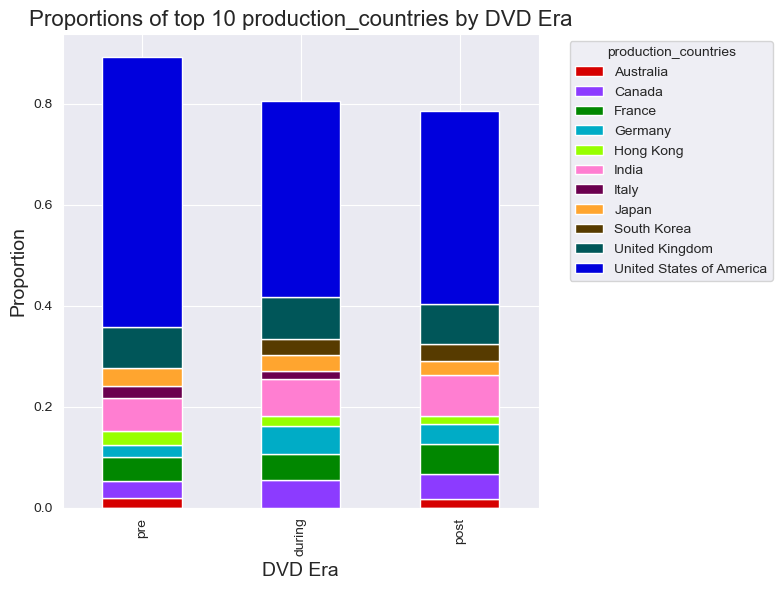

In [119]:
top_10_prod_countries = top_proportions_per_era(df_combined, 'production_countries', 10, True)
plot_top_proportions_per_era(top_10_prod_countries, 'production_countries', 10)

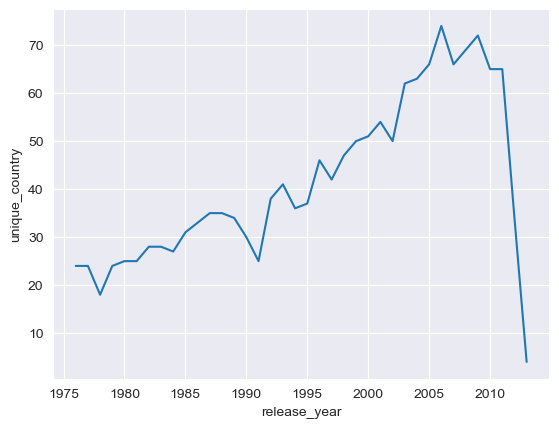

In [120]:
num_production_countries_per_year = df_combined.explode('production_countries').groupby('release_year')['production_countries'].nunique().reset_index(name='unique_country')
sns.lineplot(data=num_production_countries_per_year, x='release_year', y='unique_country')
plt.show()

## Original language

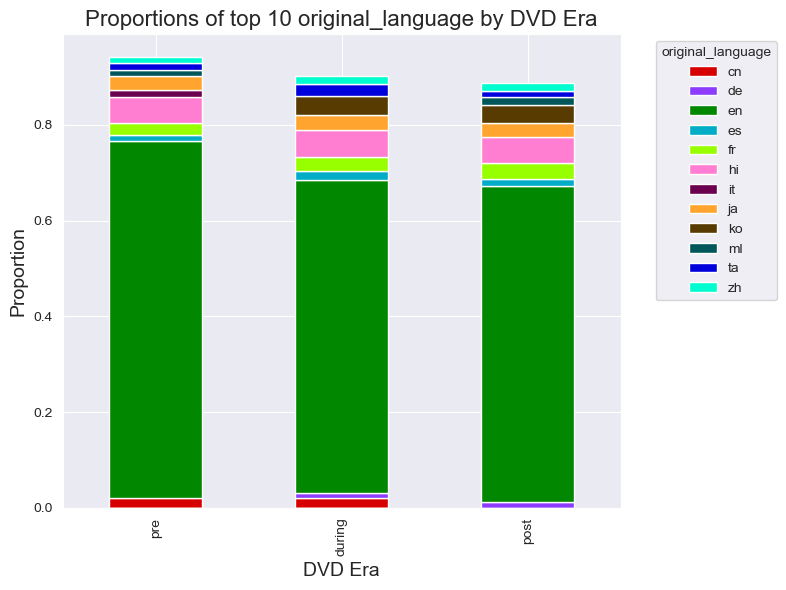

In [121]:
top_10_og_lang = top_proportions_per_era(df_combined, 'original_language', 10)
plot_top_proportions_per_era(top_10_og_lang, 'original_language', 10)

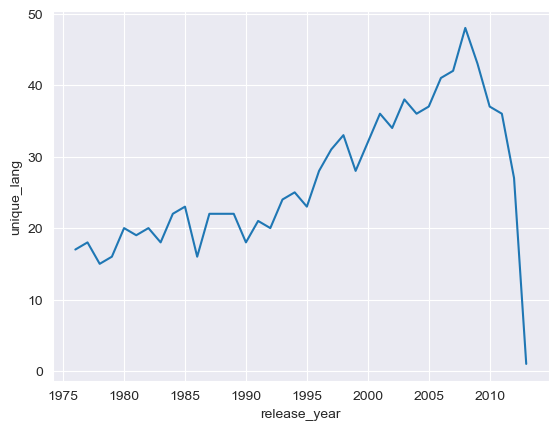

In [122]:
num_lang_per_year = df_combined.groupby('release_year')['original_language'].nunique().reset_index(name='unique_lang')
sns.lineplot(data=num_lang_per_year, x='release_year', y='unique_lang')
plt.show()

In [123]:
num_movies_per_year = df_combined.groupby('release_year').size().reset_index(name='num_movies')
num_movies_per_year.head()

,release_year,num_movies
0,1976,191
1,1977,207
2,1978,204
3,1979,221
4,1980,247


In [124]:
num_lang_per_year['ratio'] = num_lang_per_year['unique_lang'] / num_movies_per_year['num_movies']
num_lang_per_year.head()

,release_year,unique_lang,ratio
0,1976,17,0.089005
1,1977,18,0.086957
2,1978,15,0.073529
3,1979,16,0.072398
4,1980,20,0.080972


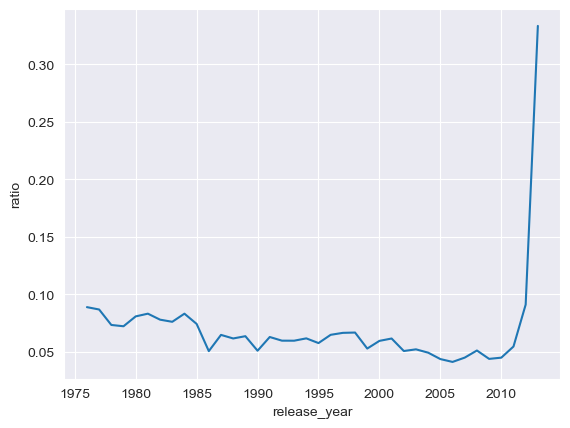

In [125]:
sns.lineplot(data=num_lang_per_year, x='release_year', y='ratio')
plt.show()

## genre


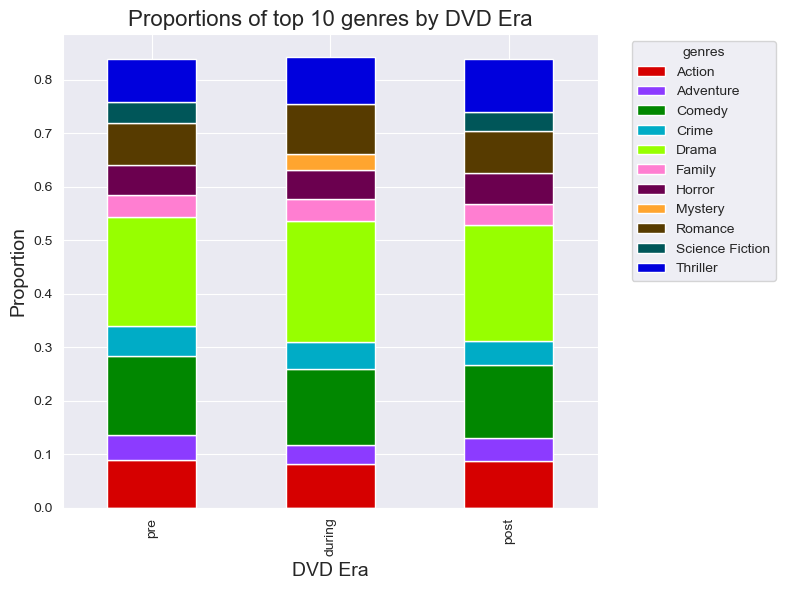

In [126]:
top_10_genre =top_proportions_per_era(df_combined, 'genres', 10, True)
plot_top_proportions_per_era(top_10_genre, 'genres', 10)

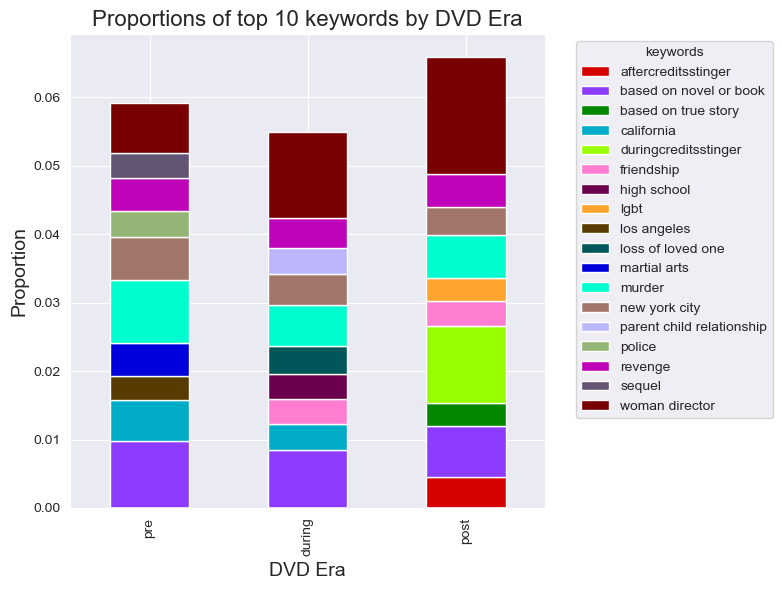

In [127]:
top_10_keyword =top_proportions_per_era(df_combined, 'keywords', 10, True)
plot_top_proportions_per_era(top_10_keyword, 'keywords', 10)

# TMDB dataset

In [128]:
df_tmdb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360791 entries, 0 to 656102
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   title                 360790 non-null  object
 1   release_date          360791 non-null  object
 2   revenue               360791 non-null  int64 
 3   runtime               360791 non-null  int64 
 4   budget                360791 non-null  int64 
 5   original_language     360791 non-null  object
 6   overview              282085 non-null  object
 7   genres                360791 non-null  object
 8   production_companies  360791 non-null  object
 9   production_countries  360791 non-null  object
 10  spoken_languages      360791 non-null  object
 11  keywords              360791 non-null  object
 12  release_year          360791 non-null  int64 
 13  dvd_era               360791 non-null  object
dtypes: int64(4), object(10)
memory usage: 41.3+ MB


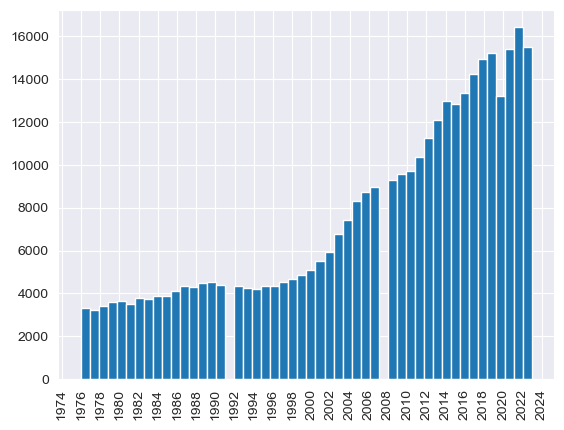

In [129]:
plt.hist(df_tmdb['release_year'], bins=50)
plt.locator_params(axis='x', nbins=50) 
plt.xticks(rotation=90)
plt.show()

In [130]:
df_tmdb['release_year'].describe()

count    360791.000000
mean       2006.722052
std          13.086210
min        1976.000000
25%        1998.000000
50%        2010.000000
75%        2018.000000
max        2023.000000
Name: release_year, dtype: float64

## Production countries

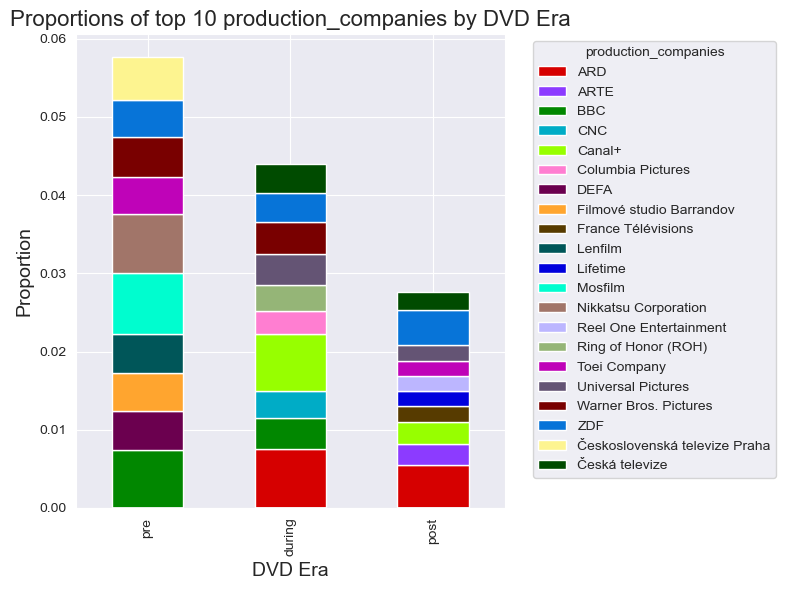

In [131]:
top_10_prod_companies = top_proportions_per_era(df_tmdb, 'production_companies', 10, islist=True)
plot_top_proportions_per_era(top_10_prod_companies, 'production_companies', 10)

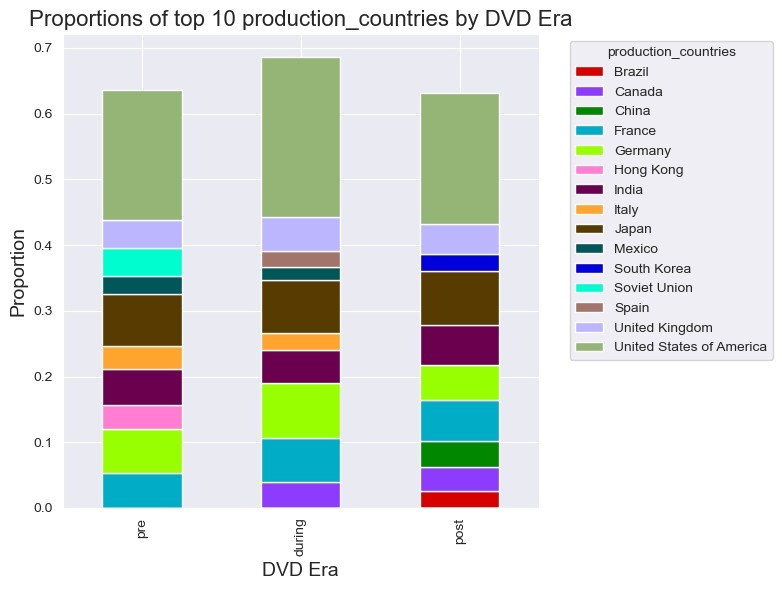

In [132]:
top_10_prod_countries = top_proportions_per_era(df_tmdb, 'production_countries', 10, islist=True)
plot_top_proportions_per_era(top_10_prod_countries, 'production_countries', 10)

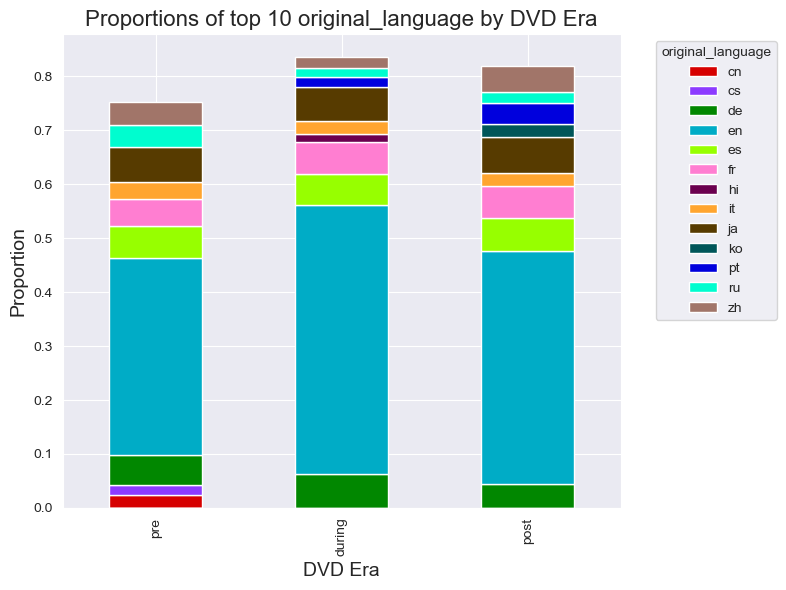

In [133]:
top_10_og_lang = top_proportions_per_era(df_tmdb, 'original_language', 10)
plot_top_proportions_per_era(top_10_og_lang, 'original_language', 10)

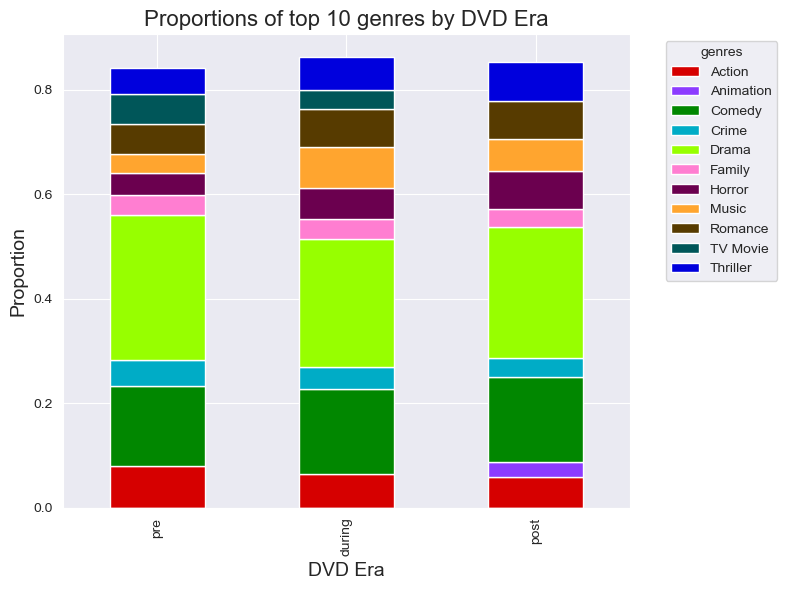

In [134]:
top_10_genre =top_proportions_per_era(df_tmdb, 'genres', 10, True)
plot_top_proportions_per_era(top_10_genre, 'genres', 10)

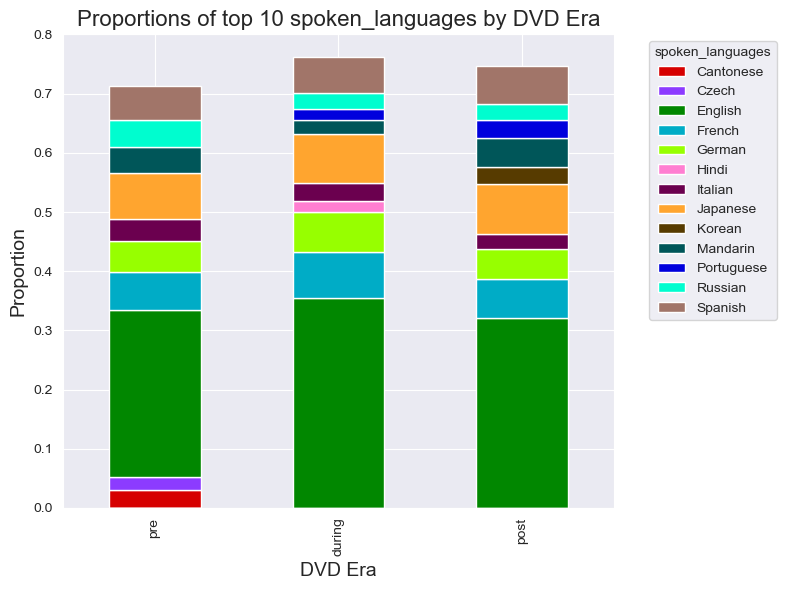

In [135]:
top_10_spoken_languages = top_proportions_per_era(df_tmdb, 'spoken_languages', 10, True)
plot_top_proportions_per_era(top_10_spoken_languages, 'spoken_languages', 10)

# Runtime


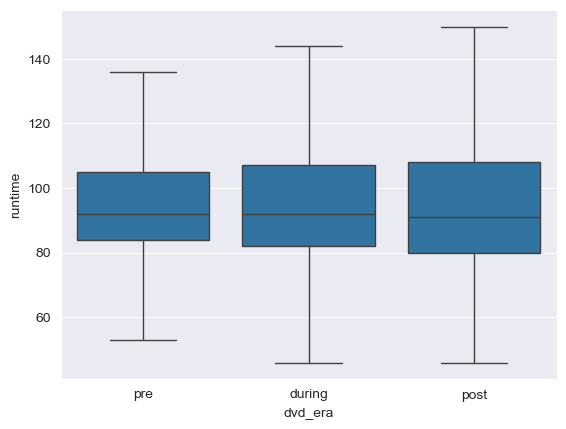

In [136]:
sns.boxplot(x='dvd_era', y='runtime', data=df_tmdb[df_tmdb['runtime'] > 0], showfliers=False, order=['pre', 'during', 'post'])
plt.show()

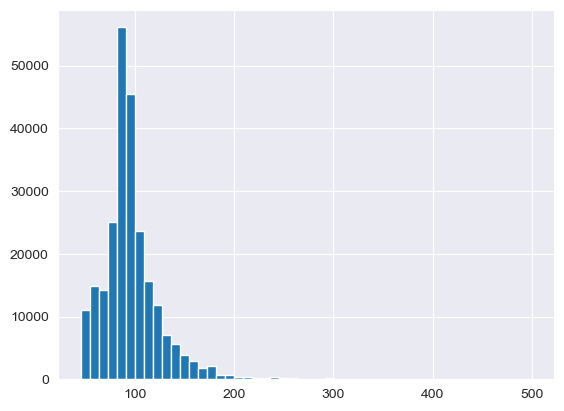

In [137]:
plt.hist(df_tmdb[(df_tmdb['runtime'] > 0)]['runtime'], bins=50)
plt.show()

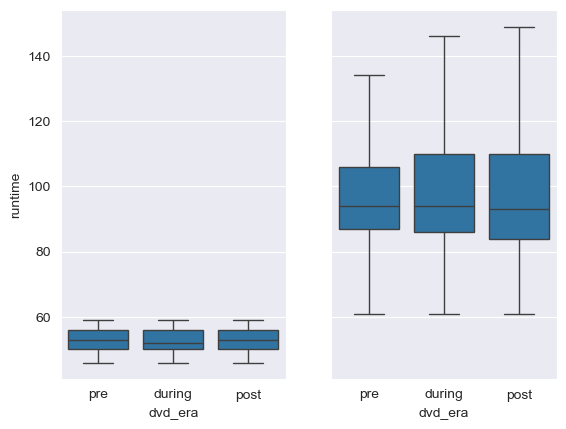

In [138]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
sns.boxplot(ax=ax1, x='dvd_era', y='runtime', data=df_tmdb[(df_tmdb['runtime'] > 0) & (df_tmdb['runtime'] < 60)], showfliers=False, order=['pre', 'during', 'post'])
sns.boxplot(ax=ax2, x='dvd_era', y='runtime', data=df_tmdb[df_tmdb['runtime'] > 60], showfliers=False, order=['pre', 'during', 'post'])
plt.show()

In [139]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# ANOVA test
anova_result = stats.f_oneway(
    df_tmdb[(df_tmdb['dvd_era'] == 'pre') & (df_tmdb.runtime > 0)]['runtime'],
    df_tmdb[(df_tmdb['dvd_era'] == 'during') & (df_tmdb.runtime > 0)]['runtime'],
    df_tmdb[(df_tmdb['dvd_era'] == 'post') & (df_tmdb.runtime > 0)]['runtime']
)

print("ANOVA result:", anova_result)

# Post hoc test if ANOVA is significant
if anova_result.pvalue < 0.05:
    tukey_result = pairwise_tukeyhsd(df_tmdb['runtime'], df_tmdb['dvd_era'])
    print(tukey_result)

ANOVA result: F_onewayResult(statistic=38.04959572330115, pvalue=3.004885074217553e-17)
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
during   post  -2.9889   0.0 -3.5559 -2.422   True
during    pre   1.6547   0.0  1.0131 2.2962   True
  post    pre   4.6436   0.0  4.1558 5.1314   True
--------------------------------------------------


In [140]:
df_tmdb[df_tmdb['runtime'] < 45].describe()

,revenue,runtime,budget,release_year
count,1.149730e+05,114973.0,1.149730e+05,114973.000000
mean,3.878086e+04,0.0,1.527981e+04,2007.794256
std,4.805076e+06,0.0,1.055179e+06,12.999357
min,0.000000e+00,0.0,0.000000e+00,1976.000000
25%,0.000000e+00,0.0,0.000000e+00,2000.000000
50%,0.000000e+00,0.0,0.000000e+00,2011.000000
75%,0.000000e+00,0.0,0.000000e+00,2018.000000
max,1.001978e+09,0.0,1.800000e+08,2023.000000


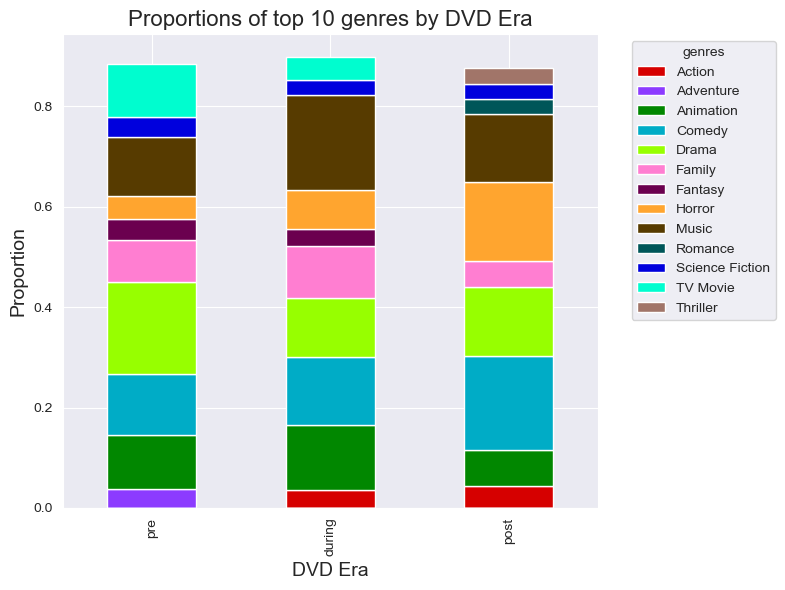

In [141]:
top_10_genre =top_proportions_per_era(df_tmdb[(df_tmdb['runtime'] < 60) & (df_tmdb['runtime'] > 0)], 'genres', 10, True)
plot_top_proportions_per_era(top_10_genre, 'genres', 10)

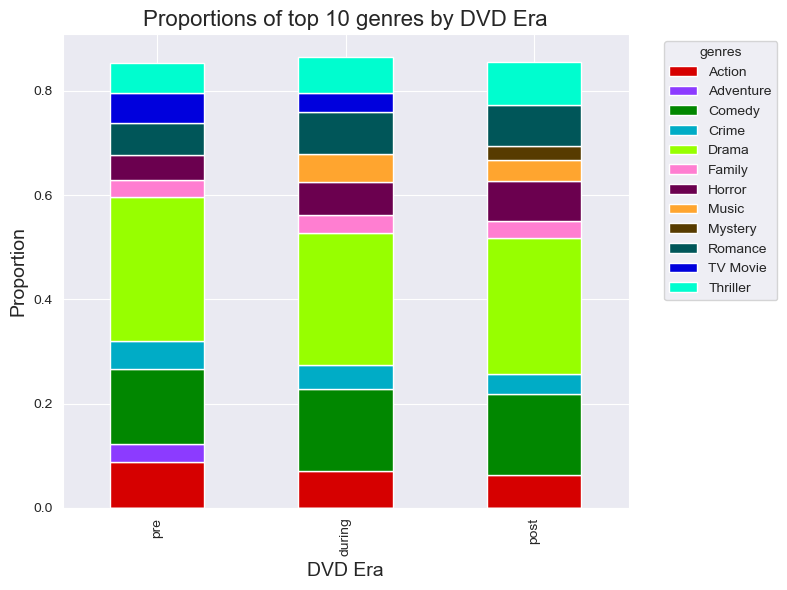

In [142]:
top_10_genre =top_proportions_per_era(df_tmdb[df_tmdb['runtime'] >= 60], 'genres', 10, True)
plot_top_proportions_per_era(top_10_genre, 'genres', 10)

# Continuous values

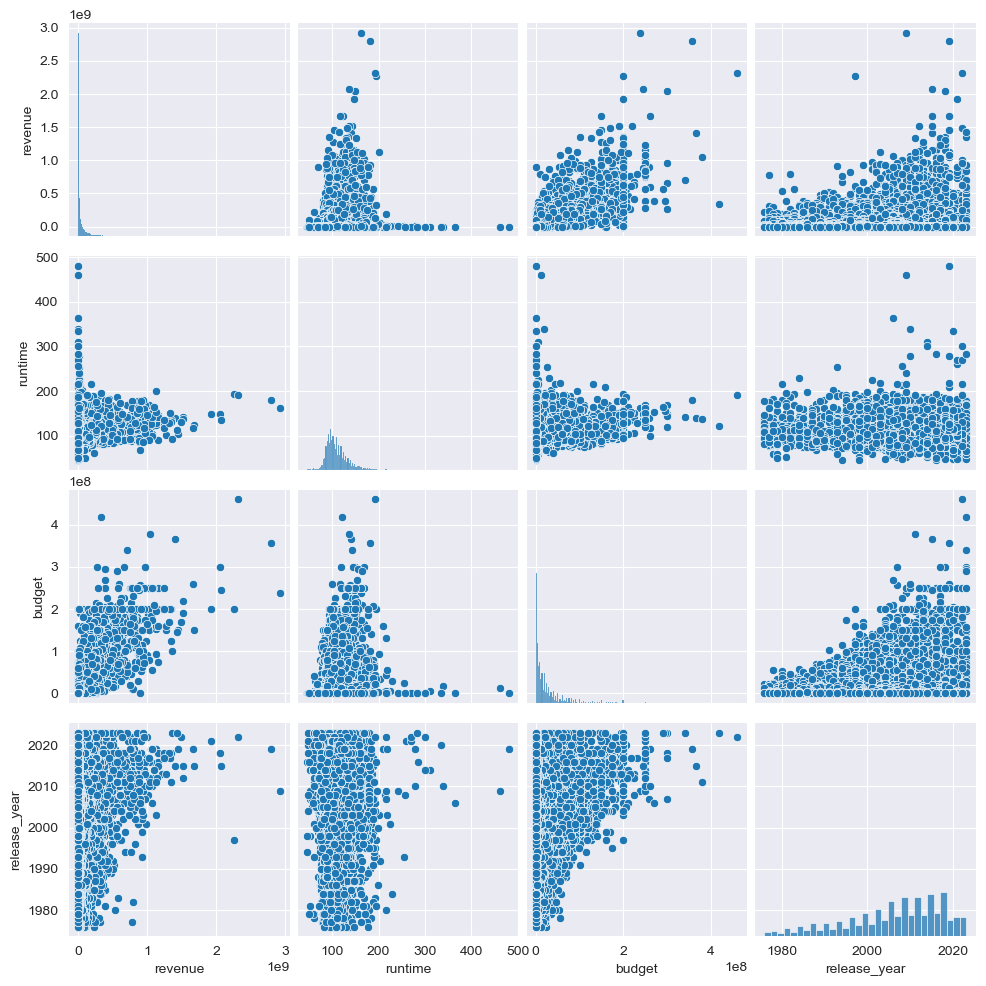

In [143]:
sns.pairplot(data=df_tmdb[(df_tmdb['runtime'] > 0) & (df_tmdb['revenue'] > 0) & (df_tmdb['budget'] > 0)])
plt.show()

# Revenue

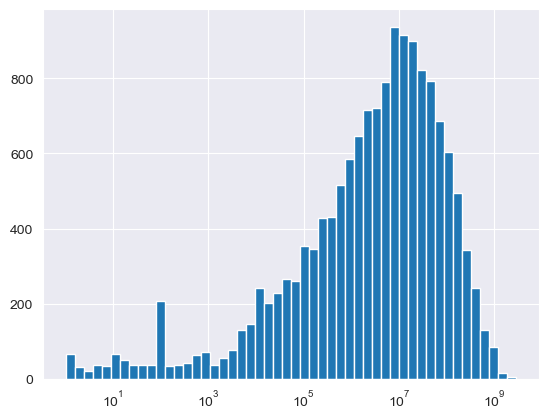

In [144]:
def plot_loghist(x, bins):
    """
    Code adapted from: https://stackoverflow.com/questions/7694298/how-to-make-a-log-log-histogram-in-python
    """
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins)
    plt.xscale('log')

plot_loghist(df_tmdb[df_tmdb['revenue'] > 0]['revenue'], 50)

# Budget

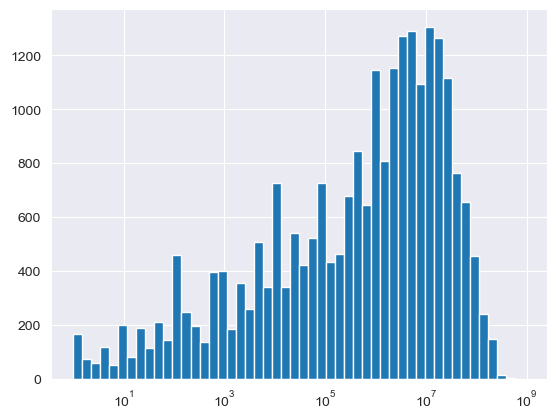

In [145]:
plot_loghist(df_tmdb[df_tmdb['budget'] > 0]['budget'], bins=50)

# Themes

In [146]:
from wordcloud import WordCloud
import nltk  # Note the spelling: nltk, not ntlk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Download stopwords
nltk.download('stopwords')  
stop_words = set(stopwords.words("english"))  
stop_words.update(['film'])
def create_wordcloud(text, additional_stop_words):
    new_stop_words = set(stopwords.words("english")).copy()
    new_stop_words.update(additional_stop_words)
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        stopwords=new_stop_words,
        max_words=100
    ).generate(text)
    
    return wordcloud

def wordcloud_per_genre(df, genre, era, additional_stop_words):
    year_texts = df[(df['genres'].apply(lambda x: genre in x)) &(df['dvd_era'] == era)]['overview'].str.cat(sep=' ')
    
    if not year_texts:
        print(f"No movies found")
        return
    
    # Create wordcloud
    wordcloud = create_wordcloud(year_texts, additional_stop_words)
    return wordcloud

def plot_wordcloud_for_year(wordcloud, genre, era):
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {genre} in {era} DVD era')
    plt.show()


[nltk_data] Downloading package stopwords to /Users/chsce/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


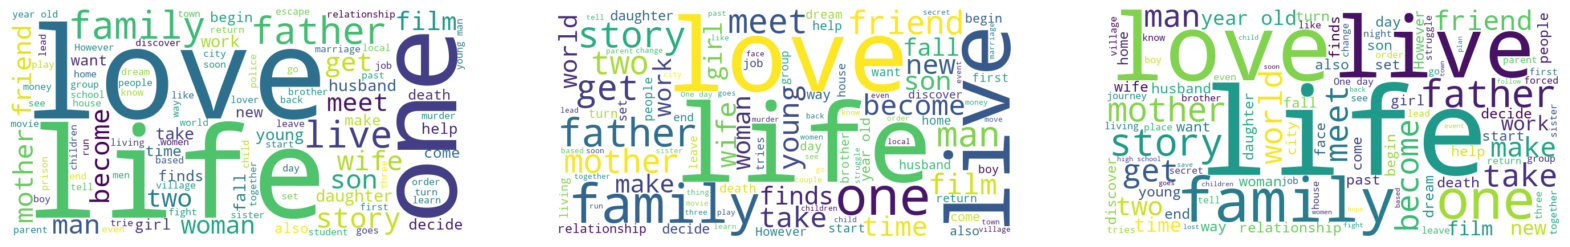

In [147]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20))
wc1 = wordcloud_per_genre(df_tmdb, 'Drama', 'pre', ["find"])  # Change year here
wc2 = wordcloud_per_genre(df_tmdb, 'Drama', 'during', ["find"])
wc3 = wordcloud_per_genre(df_tmdb, 'Drama', 'post', ["find"])
ax1.imshow(wc1, interpolation='bilinear')
ax1.axis('off')
ax2.imshow(wc2, interpolation='bilinear')
ax2.axis('off')
ax3.imshow(wc3, interpolation='bilinear')
ax3.axis('off')
plt.show()

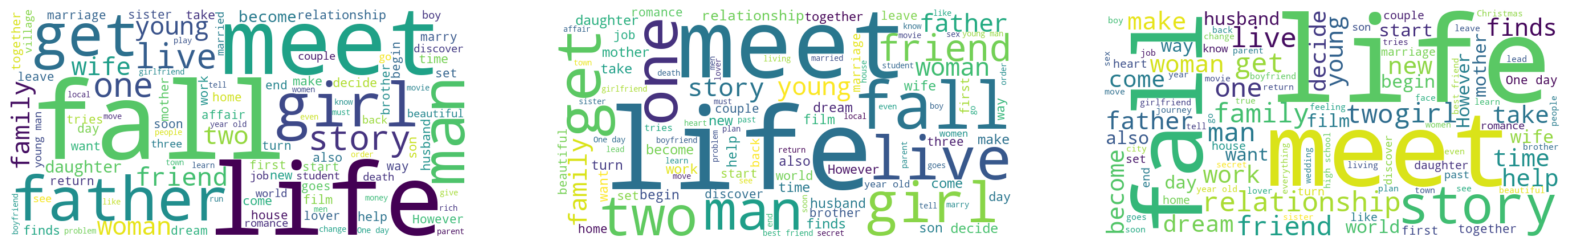

In [148]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20))
wc1 = wordcloud_per_genre(df_tmdb, 'Romance', 'pre', ["love", "find"])  # Change year here
wc2 = wordcloud_per_genre(df_tmdb, 'Romance', 'during', ["love", "find"])
wc3 = wordcloud_per_genre(df_tmdb, 'Romance', 'post', ["love", "find"])
ax1.imshow(wc1, interpolation='bilinear')
ax1.axis('off')
ax2.imshow(wc2, interpolation='bilinear')
ax2.axis('off')
ax3.imshow(wc3, interpolation='bilinear')
ax3.axis('off')
plt.show()

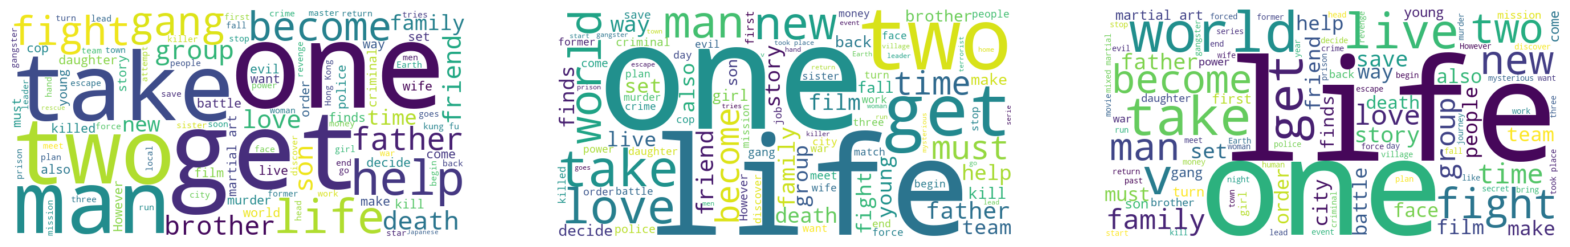

In [149]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20))
wc1 = wordcloud_per_genre(df_tmdb, 'Action', 'pre', ["find"])  # Change year here
wc2 = wordcloud_per_genre(df_tmdb, 'Action', 'during', ["find"])
wc3 = wordcloud_per_genre(df_tmdb, 'Action', 'post', ["find"])
ax1.imshow(wc1, interpolation='bilinear')
ax1.axis('off')
ax2.imshow(wc2, interpolation='bilinear')
ax2.axis('off')
ax3.imshow(wc3, interpolation='bilinear')
ax3.axis('off')
plt.show()

# Blockbusters


In [208]:
blockbusters = df_tmdb[df_tmdb['budget'] >= 1e8]

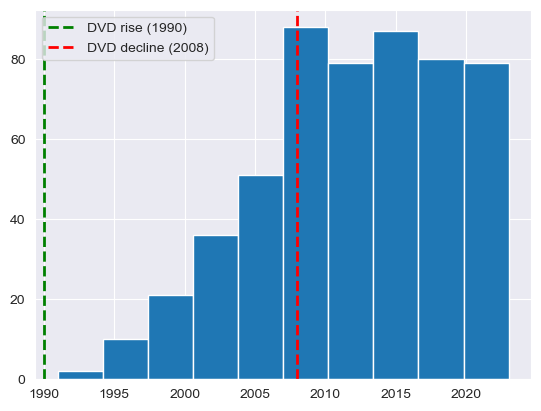

In [210]:
blockbusters.release_year.hist()
plt.axvline(x=1990, color='green', linestyle='--', linewidth=2, label=f'DVD rise ({1990})')
plt.axvline(x=2008, color='red', linestyle='--', linewidth=2, label=f'DVD decline ({2008})')
plt.legend()
plt.show()

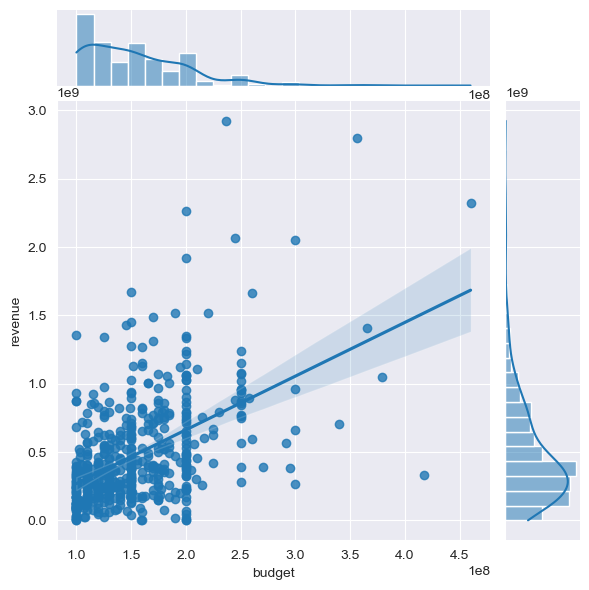

In [212]:
g = sns.jointplot(data=blockbusters[blockbusters['revenue'] > 0], x='budget', y='revenue', kind='reg')


<Axes: xlabel='release_year', ylabel='prop'>

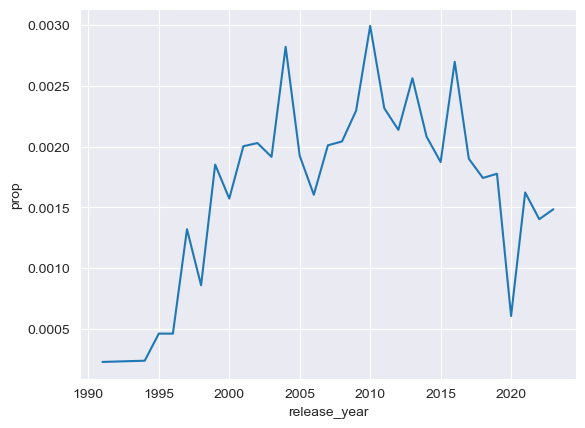

In [213]:
movies_per_year = df_tmdb.groupby('release_year').size()
prop =blockbusters.groupby('release_year').size() / movies_per_year
prop = prop.reset_index(name='prop')
sns.lineplot(prop, x='release_year', y='prop')

# Niche films


In [179]:
df_tmdb[df_tmdb.budget > 0].budget.describe()

count    2.397400e+04
mean     1.133224e+07
std      2.810748e+07
min      1.000000e+00
25%      2.000000e+04
50%      1.000000e+06
75%      9.313189e+06
max      8.880000e+08
Name: budget, dtype: float64

In [180]:
niche = df_tmdb[df_tmdb['budget'] <= 1e6]


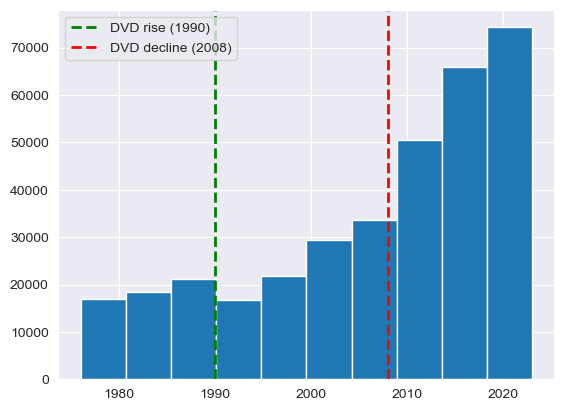

In [181]:
niche.release_year.hist()
plt.axvline(x=1990, color='green', linestyle='--', linewidth=2, label=f'DVD rise ({1990})')
plt.axvline(x=2008, color='red', linestyle='--', linewidth=2, label=f'DVD decline ({2008})')
plt.legend()
plt.show()

<Axes: xlabel='release_year', ylabel='prop'>

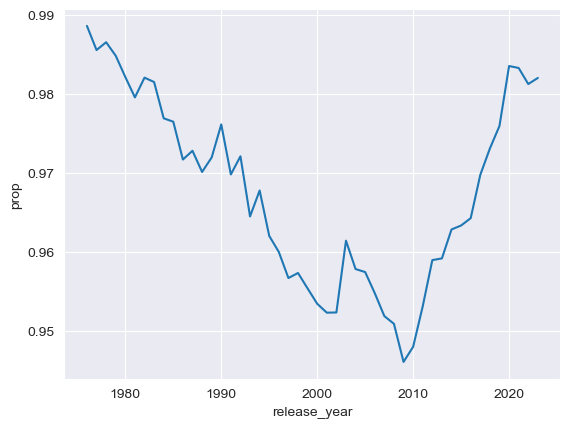

In [200]:
movies_per_year = df_tmdb.groupby('release_year').size()
prop =niche.groupby('release_year').size() / movies_per_year
prop = prop.reset_index(name='prop')
sns.lineplot(prop, x='release_year', y='prop')